## Drought analysis at NUTS-3 level
In this notebook we show how to estimate the drought impacts by fitting a power law curve. Such "damage" function will depict the relationship between the country median drought frequency and the loss as a fraction of the exposed value of sensitive sectors. We do it at NUTS-3 level.

The steps are the following:

1. Import configuration file and save parameters.
2. Import drought frequency data from parquet.
3. Import drought impact data, filter according to the configuration file and extract the drought frequency median for country and year.
4. Estimate the parameters of the power law based on the historical data.
5. Calculate the estimates of economic damages for all climate models (for the baseline).

Here the list of needed packages

In [1]:
# list of imports
import pandas as pd
import os
import re
import configparser

### Read configuration file

Configuration file contains so far only fields to filer the drought impact data in different ways

In [2]:
# import conf file using configparser
confPath = r"conf.ini"
read_config = configparser.ConfigParser()
read_config.read(confPath)

['conf.ini']

Adding a couple of simple functions to extract information from the configuration file

In [3]:
def check_boolean(bool_string):

    """ Checks that the input booleans in the conf file are valid.
    Args:
        bool_string (str): The boolean to check .
    Returns:
        bool: The correspondent python boolean.
    Raises:
        AssertionError: If boolean in the conf file is not valid.
    """

    try:
        assert bool_string.lower() == "true" or bool_string.lower() == "false", "Boolean values in the conf file are missing or mispelled. Only <True> and <False> strings are accepted. <{0}> is not valid.".format(bool_string)
    except AssertionError as err:
        raise
    else:
        if (bool_string.lower() == "true"):
            return True
        else:
            return False

In [4]:
# db path
db_folder = read_config.get("general_data", "db_path")
# extract drought impact data configuration and save to a dictionary with python types
my_complete_dict = dict(read_config.items('drought_impact_data'))
# create a dict with correct python values inside
drought_data = {"EU": check_boolean(my_complete_dict["eu_only"]),
                "LOSS_T":float(my_complete_dict["loss_threshold"]),
               "YEAR_T":int(my_complete_dict["year_threshold"]),
                "EVENTS":[word.strip().lower() for word in my_complete_dict["events"].split(',')]
               }

In [5]:
drought_data

{'EU': True, 'LOSS_T': 50.0, 'YEAR_T': 1989, 'EVENTS': ['drought', 'heatwave']}

### Import parquet file
Our frequency data are saved in the parquet format, which is provided by [apache](https://parquet.apache.org/). We can use pandas with the 'fastparquet' engine to open and access the data.

In [6]:
# filename
db_fn = "historical_zonal_stats_NUTS1.parquet" 
db_path = os.path.join(db_folder,db_fn)

In [7]:
# open file
df = pd.read_parquet(db_path, engine='fastparquet')

In [8]:
df["country_code"] = df["NUTS_ID"].str[:-1]

In [9]:
df.query("country_code=='HR' and year==2003")

,year,NUTS_ID,med,country_code
1686,2003,HR0,0.119903,HR


In [10]:
# filename
db_fn = "historical_zonal_stats_NUTS3.parquet" 
db_path = os.path.join(db_folder,db_fn)

In [11]:
# open file
df = pd.read_parquet(db_path, engine='fastparquet')

In [12]:
df.head()

,year,NUTS_ID,med
0,1990,NO0B2,-999.000000
1,1990,NO0B1,0.274340
2,1990,HR064,0.232160
3,1990,DE21A,0.665671
4,1990,DE94E,0.392419


Adding country code

In [13]:
df["country_code"] = df["NUTS_ID"].str[:-3]

In [14]:
df.query("country_code=='RS' and year==1990").med.median()

0.008699876574654208

let's take only the columns we need

In [15]:
# convert type to int 
df_slim = df.astype({'year':'int'}).copy()

### Import drought impact data (the fraction of the exposed value) and extract the drought frequency median for country and year

Drought impact data are available from a csv table which contains all events of drought or similar in the european continent.

We can filter the events based on the configuration parameters in the configuration file. For example, the following map shows the available events if the filter would be:

| Parameter's name | Value |
| ---------------- | ----- |
| year_threshold   | 1989  |
| loss_threshold   | 100   |
| eu_only          | True  |
| events           |Drought|


<img src="png/drought_intensity_100M_countries.png" width="1000">

In [16]:
# import the CSV with the impact data
filename_m= r"csv/drought_impact_all.csv"
df_mre = pd.read_csv(filename_m)

In [17]:
# uncomment to see the table
#df_mre

We want to add a few columns to the table to be able to differentiate between EU and not EU, and to add the alpha-2 ISO name

In [18]:
filename_a = r"csv/alpha2Name.csv"
df_alpha = pd.read_csv(filename_a)

In [19]:
# Create dictionaries and functions to populate the new columns using the apply method
dict_eu=dict(zip(df_alpha['ISO3'],df_alpha['EU28']))
dict_iso=dict(zip(df_alpha['ISO3'],df_alpha['ISO2']))
dict_alpha=dict(zip(df_alpha['ISO2'], df_alpha['Name']))

# small function to return the dictionaries value based on the key
def is_eu(dfs):
    return dict_eu[dfs['Country ISO3']]
def iso_2(dfs):
    return dict_iso[dfs['Country ISO3']]    
# small function to return country name
def country_name(dfs, cc):
    return dict_alpha[dfs[cc]]

In [20]:
# use the apply function of pandas to make the new column
df_mre['is_eu'] = df_mre.apply(is_eu, axis = 1)
df_mre['ISO_2'] = df_mre.apply(iso_2, axis = 1)

In [21]:
# uncomment to see the table
#df_mre

We are now ready to filter the table using the parameter in the conf file.

In [22]:
print("The following filter will be applied")
print(drought_data)

The following filter will be applied
{'EU': True, 'LOSS_T': 50.0, 'YEAR_T': 1989, 'EVENTS': ['drought', 'heatwave']}


In [23]:
df_filtered = df_mre[(df_mre["Year"]>drought_data['YEAR_T']) & 
                     (df_mre["losses"]>drought_data['LOSS_T']) & 
                     [len(set([word.strip().lower() for word in l.split(",")])&set(drought_data['EVENTS']))>0 for l in df_mre['Event Text']]].copy()

In [24]:
# uncomment to see the results
#df_filtered

In case the analysis is only for EU + UK, let's remove the countries outside the EU + UK

In [25]:
if(drought_data['EU']):
    df_filtered = df_filtered[df_filtered['is_eu']]

In [26]:
# uncomment to save the new table
#df_filtered.to_csv("new_impact_data.csv")

Finally, if i have more than one drought event per year, i should merge such events into one, by summing the respective losses.

In [27]:
# grouping events
df_to_group = df_filtered[["ISO_2","Year","losses"]].copy()
df_grouped = df_to_group.groupby(['ISO_2','Year'])

In [28]:
# check if any group as more than one event
df_grouped.count().reset_index().query("losses>1")

,ISO_2,Year,losses
7,BA,2003,2
34,HR,2003,2
38,HU,2003,2
57,RO,2001,2


In [29]:
# if any, group them
df_grouped = df_grouped.sum().reset_index()

### Import sensitive economic values at NUTS3 

Now we are ready to calculate the fraction value. The steps needed are:
* Import the expose sensitivity values
* For each event in the impact data table:
    * Collect all NUTS 3 values(for the given country and year) where the median is < 0.5 (which means the return period is higher than 2)
    * Calculate the median of all median values.
    * Sum the sensitivity value for all the NUTS 3 area identified.
    * Calculate the loss as a fraction of that value

In [30]:
# import the CSV
filename_m= r"csv/exposed_sensitivity_NUTS_3.csv"
df_exposed = pd.read_csv(filename_m)
#dict_exp=dict(zip(df_exposed['ISO_2'], df_exposed['Sensitivity']))

In [31]:
df_exposed.columns

Index(['FID', 'NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'NUTS2_ID', 'country', 'agr_C', 'agr_n3', 'ene_c', 'ene_n3', 'lsu_C',
       'lsu_n3', 'tra_C', 'tra_n3', 'wat_c', 'wat_n3', 'tot_c', 'tot_n3'],
      dtype='object')

In [32]:
def calculate_loss(x):
    nuts_sel = df_slim.query("year==@x.Year and country_code==@x.ISO_2 and 0.0<med<0.5").copy()
    return [nuts_sel.med.median(), round(df_exposed[df_exposed.NUTS_ID.isin(nuts_sel.NUTS_ID)].tot_n3.sum(),0)]

In [33]:
# calculate median values and sensitivity
df_grouped[["median_value","sensitivity"]] = df_grouped.apply(calculate_loss, axis=1, result_type='expand')
# calculate losses
df_grouped['fraction'] = df_grouped['losses']/df_grouped['sensitivity']
# threshold set to 1
df_grouped.loc[df_grouped.fraction>1, "fraction"] = 1


In [34]:
df_grouped.sort_values("ISO_2")

,ISO_2,Year,losses,median_value,sensitivity,fraction
0,AL,1990,171.85,0.018177,0.0,1.000000
1,AT,2000,146.80,0.385071,5934.0,0.024739
2,AT,2001,140.87,0.221758,5364.0,0.026262
3,AT,2003,321.02,0.211691,6909.0,0.046464
4,AT,2013,416.34,0.485812,581.0,0.716592
...,...,...,...,...,...,...
68,SI,2012,130.49,0.051265,1564.0,0.083434
69,SK,2003,185.03,0.323936,3265.0,0.056671
70,SK,2012,79.85,0.465354,1570.0,0.050860
71,UK,2003,100.75,0.127891,24064.0,0.004187


In [35]:
# take only rows where the frequency median is less than 0.5
df_grouped = df_grouped.query("0.0 < median_value < 0.5")

Now i can iterate through all the drought events and find the **median** value for the specific country and the specific year. We save the values in one list of tuples.

In [36]:
x_y_value = []
for index, row in df_grouped.iterrows():
    if(row.fraction > 0.5):
        print("\n=========")
        print(row)
    else:
        x_y_value.append((float(row.median_value),float(row.fraction)))


ISO_2                 AL
Year                1990
losses            171.85
median_value    0.018177
sensitivity          0.0
fraction             1.0
Name: 0, dtype: object

ISO_2                 AT
Year                2013
losses            416.34
median_value    0.485812
sensitivity        581.0
fraction        0.716592
Name: 4, dtype: object

ISO_2                 CH
Year                2003
losses            377.82
median_value    0.458657
sensitivity          0.0
fraction             1.0
Name: 11, dtype: object

ISO_2                 LT
Year                1992
losses             77.45
median_value    0.485243
sensitivity         62.0
fraction             1.0
Name: 45, dtype: object

ISO_2                 MK
Year                1993
losses            280.79
median_value    0.064079
sensitivity          0.0
fraction             1.0
Name: 48, dtype: object

ISO_2                 PT
Year                1997
losses             206.1
median_value    0.482049
sensitivity         95.0
f

## Base curve fitting

In addition to plotting data points from our observations and models, we must often fit them to a theoretical model to extract important parameters. In this case we will use a  __power-law__.

`curve_fit` method is used to estimate the parameters for the power law

In [37]:
# importing modules.
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

The general formula of the power law can be expressed as:
$$y=ax^b$$

First, we define the function for the power law in python

In [33]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

Convert python list to np array and sort it by x values

In [34]:
x_y = np.array(x_y_value)
x_y = x_y[x_y[:,0].argsort()]
# save x as sep array
x = x_y[:, 0]
# save y as sep array
y = x_y[:,1]

In [35]:
#from bokeh.plotting import figure, show
import pandas_bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [36]:
#x_y_value

In [37]:
df_plot = pd.DataFrame(x_y_value, columns =['frequency', 'damage']) 

In [38]:
p = figure(plot_width=1000, plot_height=600, title = "prova",tools="pan,wheel_zoom,box_zoom,reset,hover")
p.circle('median_value','fraction',source=df_grouped,fill_alpha=0.2, size=10)

GlyphRenderer(id='1039', ...)

In [39]:
show(p)

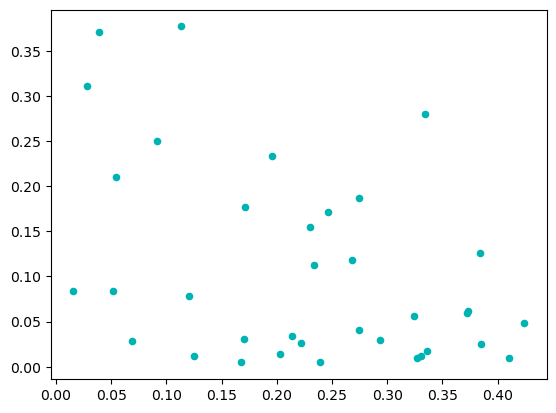

In [40]:
# Plot the  data
fig, ax = plt.subplots()
#plt.xlim([0,1])
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')

An often more-useful method of visualizing exponential data is with a logarithmic plot since it linearizes the data. To set the scale of the x and y-axis from linear to logarithmic, we add the following line:

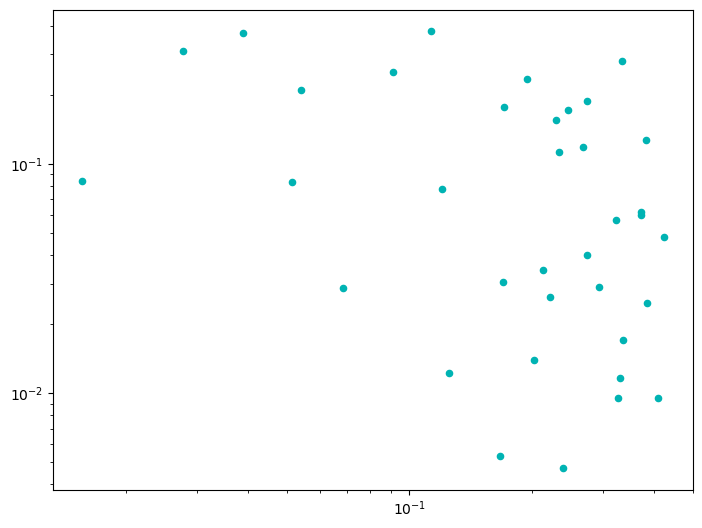

In [41]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Set the x and y-axis scaling to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')
# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
# Set the axis limits TODO
#ax.set_xlim(10, 1000)
#ax.set_ylim(1, 100)
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')

We can now fit our data to the power law function to extract the a and b parameters, and superimpose the fit on the data. Note that although we have presented a log plot above, we have not actually changed the x and y-data - we have only changed the scale of the x and y-axis. So, we are still fitting the non-linear data, which is typically better as linearizing the data before fitting can change the residuals and variances of the fit.

__curve_fit__

INPUTS:

* `f` — function used for fitting (in this case exponential)
* `xdata` — array of x-data for fitting
* `ydata` — array of y-data for fitting
* `p0` — array of initial guesses for the fitting parameters (both a and b as 0)
* `bounds` — bounds for the parameters (-∞ to ∞)

OUTPUTS:

* `pars` — array of parameters from fit (in this case [a, b])
* `cov` — the estimated covariance of pars which can be used to determine the standard deviations of the fitting parameters (square roots of the diagonals)

In [42]:
# TODO MAKE IT WEIGHTED
pars, cov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))
# Calculate the residuals
res = y - power_law(x, *pars)

We can extract the parameters and their standard deviations from the `curve_fit` outputs, and calculate the residuals by subtracting the calculated value (from our fit) from the actual observed values (our dummy data)

In [43]:
print("Fit parameters and standard deviations:")
print("a=", round(pars[0], 5), "+-", round(stdevs[0], 3))
print("b=", round(pars[1], 5), "+-", round(stdevs[1], 3))
print("Paper parameters:")
print("a= 0.04756")
print("b= -0.48652")
parameter_a = pars[0]
parameter_b = pars[1]
parameter_a_paper = 0.04756
parameter_b_paper = -0.48652

Fit parameters and standard deviations:
a= 0.05557 +- 0.02
b= -0.35915 +- 0.138
Paper parameters:
a= 0.04756
b= -0.48652


Let's now plot the fitted curve.
`*pars` — allows us to unroll the pars array, i.e. [a, b] gets inputted as a, b

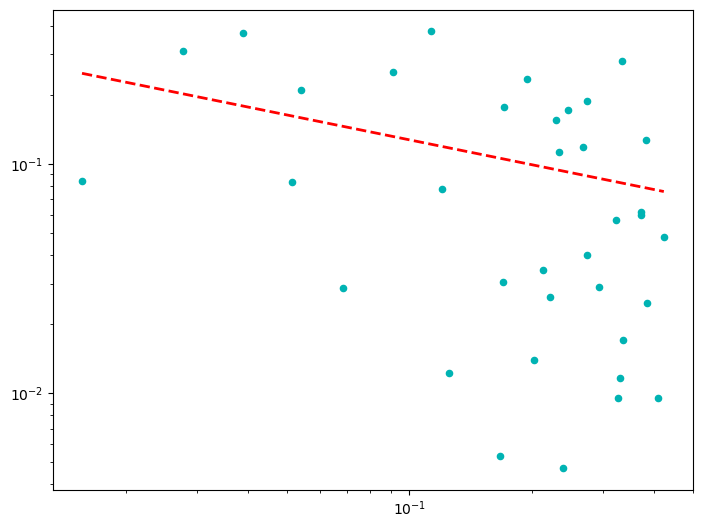

In [44]:
# Plot the fit data as an overlay on the scatter data
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Set the x and y-axis scaling to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')
# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
# Set the axis limits
#ax.set_xlim(10, 1000)
#ax.set_ylim(1, 100)
ax.scatter(x, y, s=20, color='#00b3b3', label='Data')
ax.plot(x, power_law(x, *pars), linestyle='--', linewidth=2, color='red')

Finally let's visualize the curve not log-scaled

In [45]:
conf =[]
conf.append([pars[0]-stdevs[0],pars[1]+stdevs[1]])
conf.append([pars[0]+stdevs[0],pars[1]-stdevs[1]])

(0.0, 0.5)

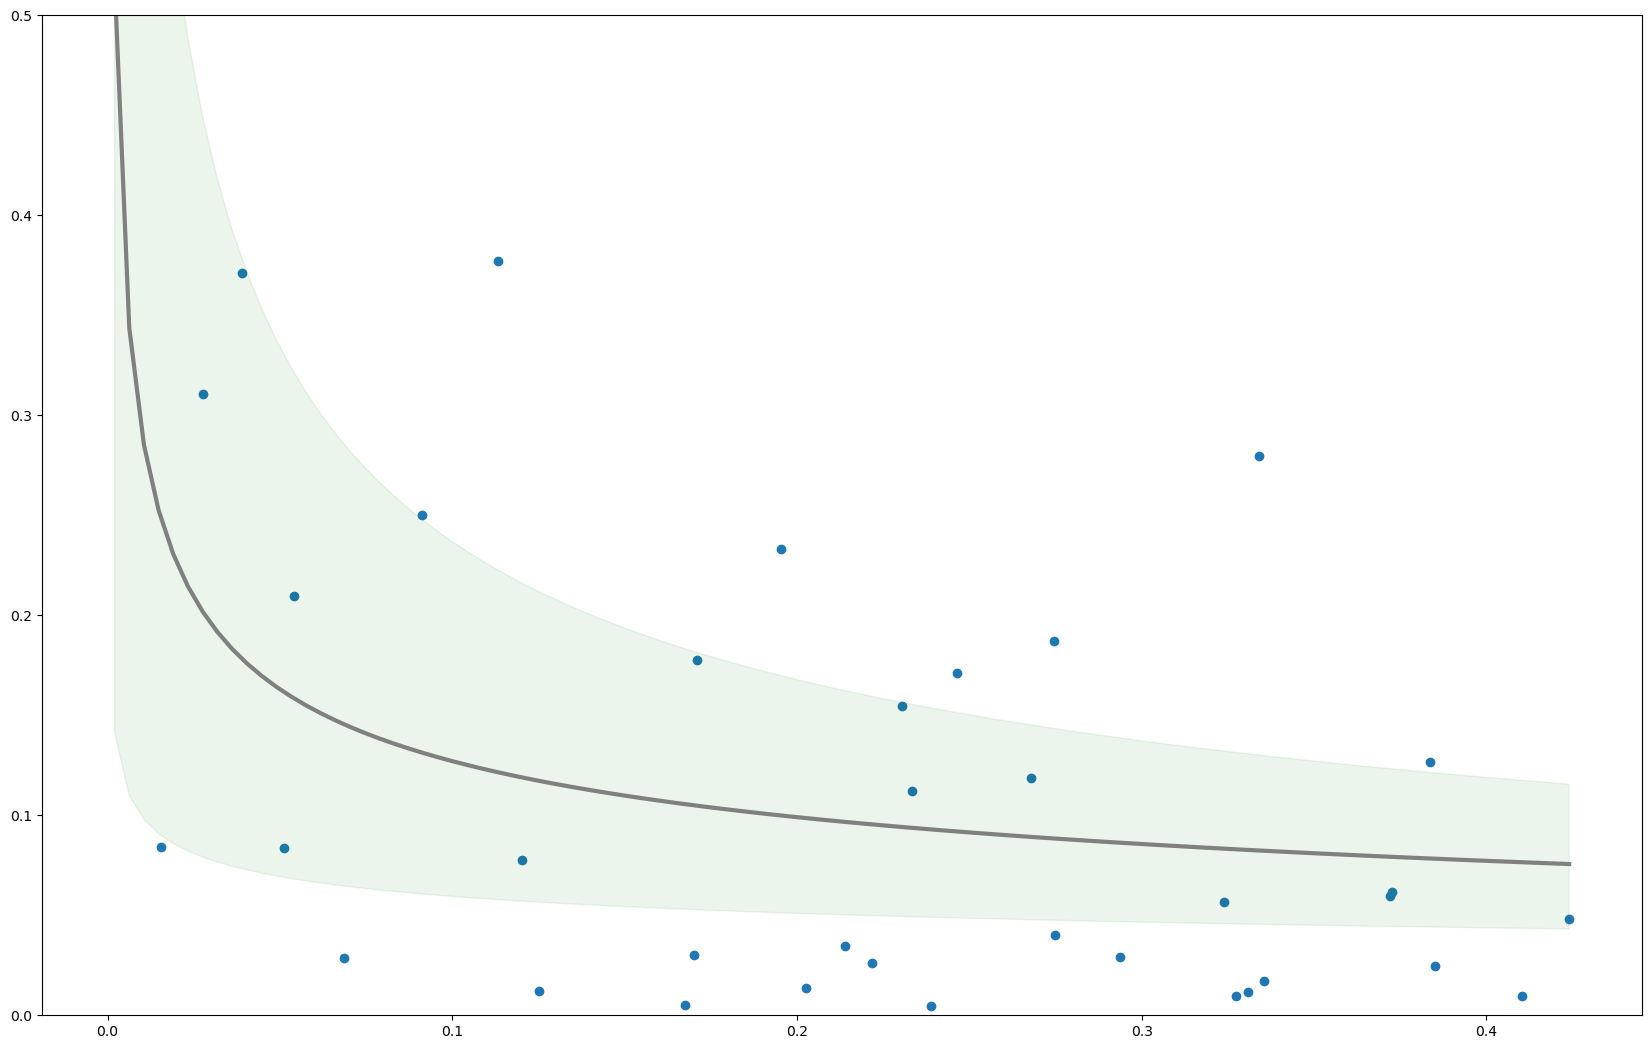

In [46]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_axes([0.0, 0, 1, 1])
x_ranged = np.linspace(0.002,x.max(), 100) 

# plotting obs
ax.scatter(x,y)

# plotting fitted curve
ax.plot(x_ranged, power_law(x_ranged, *pars), linewidth=3, color='grey')

# plotting the confidence intervals (std devs)
ax.fill_between(x_ranged, power_law(x_ranged, *conf[0]), power_law(x_ranged, *conf[1]),
                 color = 'green', alpha = 0.08)

plt.ylim(0,0.5)

## Estimates of economic damages

Estimates of direct economic damages are expressed in €2015 values, and they were obtained as follows. For all climate realizations of the ensemble, we combine for each 30-year time window (baseline and periods centred on the GWLs) the hazard, exposure and damage function in the following way. For each year of a 30-year time window, the median frequency of the simulated annual  minimum flow is obtained over all river pixels with upstream area >1,000 km2 in 
a country. This value is then plugged into the damage function (central estimate in Supplementary Fig. 4, x-axis) to determine the loss as a fraction of the exposed sensitive value. So in country A, an event in year i with a probability to happen once every 5 years (frequency = 0.2, or return period of 5 years), would result in a 10% loss of the exposed sensitive value in that country. Multiplication with the present (baseline, Supplementary Table 4) or future (end of century, Supplementary  Table 5) exposed sensitive value for country A then provides a quantitative estimate  of the drought losses for country A in year i. For each climate realization, the  country expected annual damage at the GWLs was then obtained by taking the  average loss over the 30 years of estimated annual losses in the respective periods.  We note that when considering extremes, it is important to take the average impact  over all simulated events and not the median, as there is large skew in the impact  distribution (inherent to extreme events) and the low-probability high-impact  events have an important weight in the expected annual losses. The uncertainty in  the fitted damage function (dotted lines in Supplementary Fig. 4) was translated  into impact estimates through loss estimations for the 5% and 95% uncertainty  bounds of the fitted vulnerability function for each climate realization. The total uncertainty in our damage estimates thus reflects the variability in future climate at the warming levels as defined by the climate ensemble and the uncertainty in the relation between damages and drought hazard.

In [47]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [48]:
prj_path = os.path.join(db_folder,"zonal_stats_NUTS3_filled.parquet")

In [49]:
prj_df = pd.read_parquet(prj_path, engine='fastparquet')

In [50]:
prj_df.drop(['NUTS_ID_2', 'NUTS_ID_1','NUTS_ID_0','new_med'], axis=1,inplace=True)

In [51]:
prj_df = prj_df[prj_df['year']<2011].copy()

In [52]:
prj_df['country_code'] = prj_df['NUTS_ID'].str[:-3]

In [53]:
# cap to 0.002 as lowest
prj_df.loc[(prj_df["med"] < 0.002) & (prj_df["med"] > 0.0), "med"] = 0.002

Group results by model, rcp, year and country code

In [54]:
#for index, row in dbf_prj.dbf_df.iterrows():
grouped_prj_result = prj_df.groupby(['model','rcp','year','country_code'])

In [55]:
#for index, row in dbf_prj.dbf_df.iterrows():
prj_df_2 = prj_df.query("0.0<med<0.5").copy()
grouped_prj_result_2 = prj_df_2.groupby(['model','rcp','year','country_code'])

Now we iterate over the groups, calculate both the median for each group and the exposed value.

In [56]:
# add a progress bar
max_count = len(grouped_prj_result)
flag = True
f = IntProgress(min=0, max=max_count) # instantiate the bar

print("Progress:")
display(f) # display the bar

# let's find the exposed sensitivity value for each group
df_new = pd.DataFrame(columns=['model', 'rcp', 'year', 'country_code', 'exp_sum', 'freq_med'])

# iterate over all groups
for name, group in grouped_prj_result:
    f.value += 1
    
    # check if it is in EU
    if(name[3] in df_exposed.CNTR_CODE.unique()):
        
        exposed_sum = 0
        frequency_median = 0
        
        # check if we have at least one value less than 0.5 and above 0.0
        if(name in grouped_prj_result_2.groups):
            
            # here we select, for country i, all NUTS_ID where the frequency is lower than 0.5
            group_2 = grouped_prj_result_2.get_group(name)
            # the total exposed sensitivity is calculated as a sum of the exposed sensitivities of above NUTS_ID 
            exposed_sum = df_exposed[df_exposed.NUTS_ID.isin(group_2.NUTS_ID)].tot_n3.sum()
            # calculate median frequency using only the above NUTS_ID
            frequency_median = group_2.med.median()

            # calculate loss using the power law params
            if(frequency_median > 0.00 and frequency_median < 0.5):

                # calculate the value using the fitted curve
                loss = power_law(frequency_median, parameter_a, parameter_b) * exposed_sum

            else:
                # it means that we did have NUTS_ID with value less than 0.5 but the median got above
                # in theory, i shall not enter this else statement
                #if(flag): print("Following countries (per models and rcp) have frequency median above 0.5 or equal to 0")
                loss = 0

        else:
            # it means we do not have any NUTS ID less than 0.5 in the entire country, therefore we do not have losses
            loss = 0
            #if(name[3]!="MT"): print(name)

        
        # calculate new row for each group and add to new dataframe
        new_row = pd.DataFrame({'model': name[0], # model we just analyzed
                                'rcp': name[1], # rcp
                                'year': name[2], # year
                                'country_code': name[3],  
                                'exp_sum': exposed_sum, 
                                'freq_med': frequency_median,
                                'loss': loss}, index=[0])

        df_new = pd.concat([df_new,new_row]).reset_index(drop=True)
print("Done!")

Progress:


IntProgress(value=0, max=18480)

Done!


Now we can aggregate the results by taking the mean over the 30 years window and save the columns with model and rcp information

In [57]:
df_new.query("country_code=='MT'")

,model,rcp,year,country_code,exp_sum,freq_med,loss
19,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,1981,MT,0.0,0.0,0.0
47,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,1982,MT,0.0,0.0,0.0
75,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,1983,MT,0.0,0.0,0.0
103,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,1984,MT,0.0,0.0,0.0
131,CLMcom-CCLM4-8-17_BC_CNRM-CERFACS-CNRM-CM5,45,1985,MT,0.0,0.0,0.0
...,...,...,...,...,...,...,...
18359,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,2006,MT,0.0,0.0,0.0
18387,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,2007,MT,0.0,0.0,0.0
18415,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,2008,MT,0.0,0.0,0.0
18443,SMHI-RCA4_BC_MPI-M-MPI-ESM-LR,85,2009,MT,0.0,0.0,0.0


In [58]:
final_mean = df_new.groupby([df_new.model,df_new.rcp,df_new.country_code]).mean(numeric_only = True).round(2).reset_index()

In [59]:
final_mean = final_mean.groupby("country_code").mean(numeric_only = True).round(2).reset_index()

In [60]:
#final_mean = final_mean.reset_index()

# adding the country name
final_mean['country_name'] = final_mean.apply(country_name, args=("country_code",), axis = 1)

Here the final results

In [61]:
final_mean = final_mean.sort_values("country_name")


In [62]:
final_mean.columns

Index(['country_code', 'rcp', 'exp_sum', 'freq_med', 'loss', 'country_name'], dtype='object')

In [63]:
final_mean[['country_name','loss']]

,country_name,loss
0,Austria,593.23
1,Belgium,478.32
2,Bulgaria,136.25
12,Croatia,105.98
3,Cyprus,47.94
4,Czech Republic,352.47
6,Denmark,272.71
7,Estonia,24.36
10,Finland,298.79
11,France,3211.43


### Compare results with paper

In [64]:
# paper
d = {'country': ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia','Spain','Sweden','United Kingdom'], 
     'loss': [244,210,89,72,38,169,121,14,66,1244,996,326,162,122,1395,18,29,20,13,265,338,252,388,84,45,1487,157,686]}
df = pd.DataFrame(data=d)
inv_map = {v: k for k, v in dict_alpha.items()}

In [65]:
def country_code(dfs):
    return inv_map[dfs['country']]

In [66]:
df['country_code'] = df.apply(country_code, axis = 1)

In [67]:
# use the apply function of pandas to make the new column
#df['exp'] = df.apply(country_exp, axis = 1)
#df['med_ref'] = pow((df['loss'] / df['exp'])/parameter_a_paper,1/parameter_b_paper)

In [68]:
final_mean = final_mean.rename(columns={"loss":"cm_loss"}).drop(['rcp', 'exp_sum', 'freq_med', 'country_name'],axis=1)

In [69]:
f_results = pd.merge(df,final_mean,how='inner',on='country_code')

In [70]:
f_results

,country,loss,country_code,cm_loss
0,Austria,244,AT,593.23
1,Belgium,210,BE,478.32
2,Bulgaria,89,BG,136.25
3,Croatia,72,HR,105.98
4,Cyprus,38,CY,47.94
5,Czech Republic,169,CZ,352.47
6,Denmark,121,DK,272.71
7,Estonia,14,EE,24.36
8,Finland,66,FI,298.79
9,France,1244,FR,3211.43


In [71]:
f_results["diff"] = round(f_results.cm_loss - f_results.loss,0)

In [72]:
f_results.drop("country_code",axis=1).style.background_gradient(axis=None,cmap='YlOrRd', subset=['diff']) 

,country,loss,cm_loss,diff
0,Austria,244,593.230000,349.000000
1,Belgium,210,478.320000,268.000000
2,Bulgaria,89,136.250000,47.000000
3,Croatia,72,105.980000,34.000000
4,Cyprus,38,47.940000,10.000000
5,Czech Republic,169,352.470000,183.000000
6,Denmark,121,272.710000,152.000000
7,Estonia,14,24.360000,10.000000
8,Finland,66,298.790000,233.000000
9,France,1244,3211.430000,1967.000000


### Compare results with NUTS-0

In [73]:
# import file
nuts_0_res = pd.read_parquet('results/nuts_0.parquet', engine='fastparquet')
nuts_0_res = nuts_0_res.rename(columns={"NUTS_ID":"country_code"})

In [74]:
f_results_2 = pd.merge(nuts_0_res,final_mean,how='inner',on='country_code')

In [75]:
f_results_2["diff"] = round(f_results_2.cm_loss - f_results_2.loss,0)

In [76]:
# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# swap points and rebounds columns
f_results_2 = swap_columns(f_results_2, 'country_name', 'loss')

In [77]:
f_results_2.drop("country_code",axis=1).style.background_gradient(axis=None,cmap='YlOrRd', subset=['diff']) 

,country_name,loss,cm_loss,diff
0,Austria,206.311585,593.230000,387.000000
1,Belgium,233.948539,478.320000,244.000000
2,Bulgaria,58.834608,136.250000,77.000000
3,Cyprus,38.707749,47.940000,9.000000
4,Czech Republic,167.634186,352.470000,185.000000
5,Germany,1580.984366,3378.530000,1798.000000
6,Denmark,146.300549,272.710000,126.000000
7,Estonia,9.534682,24.360000,15.000000
8,Greece,177.001765,429.350000,252.000000
9,Spain,715.745667,2257.100000,1541.000000
